In [2]:
from IPython.core.display import HTML
HTML("""
<style>

div.cell { /* Tunes the space between cells */
margin-top:1em;
margin-bottom:1em;
}

div.text_cell_render h1 { /* Main titles bigger, centered */
font-size: 2.2em;
line-height:1.4em;
text-align:center;
}

div.text_cell_render h2 { /*  Parts names nearer from text */
margin-bottom: -0.4em;
}


div.text_cell_render { /* Customize text cells */
font-family: 'Times New Roman';
font-size:1.5em;
line-height:1.4em;
padding-left:3em;
padding-right:3em;
}
</style>
""")

# Objectives

In this notebook,i simulate a single gaussian shaped object (source) and use nested sampling coupled with mcmc to do inference on the parameters of the source. That is basically doing source finding by recovering the parameters of the source, which are X,Y location,A flux and R spatial extent.

In [3]:
########################Import Modules##########################################
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import corner
import copy as duplicate
import time
from matplotlib import colors
import scipy as sp

from ipywidgets import IntProgress
from IPython.display import display

from mpl_toolkits.axes_grid1 import make_axes_locatable

from matplotlib.patches import Ellipse
from matplotlib.collections import PatchCollection

#####################################

### TODO: Define Gaussian shaped function

$$\tau(X,Y,A,R) = A\exp{[-\frac{(x-X)^{2} + (y-Y)^{2}}{2R^{2}}]}$$

 - X , Y are the position or location of the source
 - A is the flux or Amplitude of the source
 - and R is the spatial extent of the source
### the above equation is used to model each source.

In [4]:
def Template_Equation(x,y,theta):
    """
         Returns Gaussian shaped Function
    
    Parameters
    
    ---------------------
    x:  array  (1,nunmber of pixels)
        column vector
        
    y:  array (number of pixels,1)
        row vector
        
    theta : list or array
            List of parameters X , Y and A.
            
    params: list or array
            x,y - row by coloumn pix
    ---------------------- 
    
    output: Dataset
            pix by pix model"""
    
    X,Y,A = theta
    R = 3                 # Keeping the spatil extent constant
    template = A*np.exp(-(((x-X)**2 + (y-Y)**2)/(2*R**2)))
    return template

# Prior on [X,Y,A]
TODO : Define functions of the prior probability on X , Y and A,

The prior probabilities on X and Y are flat priors definied by.
                
$$P(X) = \frac{1}{X_{upper}-X_{lower}}$$
$$P(Y) = \frac{1}{Y_{upper}-Y_{lower}}$$
                    
and the prior on A is an exponential prior.
                        $$P(A) = \exp{(-A)}$$

In [5]:
def LogPrior(theta,theta_limits):
    """Evaluate the prior probability of each X,Y and A
    
    Parameters
    
    ----------------
    
    theta : list or array
            [X,Y,A] parameters to be evaluated
            
    theta_limits: list or array 
            The limits of X,Y and A.
    
    ----------------
     output: scalar
            The log Prior of X,Y and A.
    
    """
    
    X,Y,A = theta
    
    Xlimits,Ylimits = theta_limits
    
    if (X < Xlimits[0]) | (X > Xlimits[1]):  #If position is out of limits discard 
        log_X_prior = -np.inf
    else:
        log_X_prior = np.log(1.0/(Xlimits[1] - Xlimits[0]))
        
    if (Y < Ylimits[0]) | (Y > Ylimits[1]):
        log_Y_prior = -np.inf
    else:
        log_Y_prior = np.log(1.0/(Ylimits[1] - Ylimits[0]))
    
    if (A<0):           # Positive flux
        log_A_prior = -np.inf
    else:
        log_A_prior = -A
    
    return log_X_prior + log_Y_prior + log_A_prior

# Likelihood

TODO: I define a Gaussian log-likelihood function given by;

$$\log{L} = \sum_{i}^{n}{\log{(\frac{1}{\sqrt{2\pi\sigma_{i}^{2}}}})} + \sum_{i}^{n}{-\frac{(D_i - model)^{2}}{2\sigma_{i}^{2}}}$$

 - $\sigma_{i}$ is noise of each pixel
 - $D_{i}$ is the data in each pixel
 - model is the data model of each pixel

In [6]:
def LogL(theta,data,sigmay):
    """Returns the log-likelihood the of the model given Gaussian measurement noise with standard
    deviation with known *sigmay*, where "y_data" is the known data values 
    
    Parameters
    
    ----------------
    
    model : Function
            Model function
    theta: list or array
            model parameters [X,Y,A]
    
    data : matrix
            Image data
    sigmay : matrix
            each pixel noise (Gaussian noise)
    
    ----------------
    Output: scalar
            log likelihood"""
    y_data = data
    model = Template_Equation(x,y,theta)
    logL = (np.sum(np.log(1./(np.sqrt((2.*np.pi)*sigmay**2)))) +
            np.sum(-0.5 * (y_data - model)**2 / sigmay**2))
    return logL

In [7]:
def Get_particles_from_prior():   # Sampling from the prior space
    
    
    X = sp.stats.uniform.rvs(0,npix)
    Y = sp.stats.uniform.rvs(0,npix)
    A = sp.stats.uniform.rvs(5,20)
    theta = [X,Y,A]
    return theta

# Simulated Image

I simulate an image of dimension 50x50 pixels with sigma noise of 1.0 using the gaussian shaped function.

Text(0,0.5,'Arbitrary Flux')

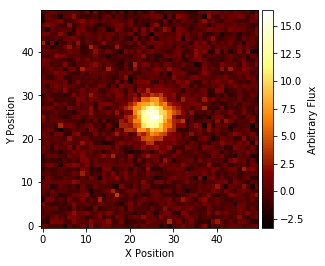

In [8]:
npix = 50    # number of pixels
x = np.arange(0, npix, 1, float)
y = x[:,np.newaxis]


#Locations ,Spatial extent and Flux
X = 25
Y = 25
A = 15

theta_pic = np.array([X,Y,A])

#Gaussian Noise
noise_sigma = 1.0
Noise = np.random.normal(0,noise_sigma,(npix,npix))

# Image data
Img_data = Template_Equation(x,y,theta_pic) + Noise

ax = plt.subplot(111)
im = ax.imshow(Img_data,origin='lower',cmap='afmhot',)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
plt.ylabel('Arbitrary Flux')

# Generate walkers

In [19]:
#Generate walkers

#Number of walkers
N = 150

particles = []
logp = np.empty(N)
logl = np.empty(N)

#Data and Noise 
data = Img_data
sigmay = Noise

#parameter limits
Xlimits = [0.0, npix]
Ylimits = [0.0,npix]
theta_limits = (Xlimits, Ylimits)

# Generate walkers
for i in range(0, N):
    theta = Get_particles_from_prior()
    #Save each sample
    particles.append(theta) 
    
    # Save Likelihood of each sample
    logl[i] = LogL(theta,data,sigmay)  
    
    #Save prior prob of each sample
    logp[i] = LogPrior(theta,theta_limits)     

# Initialize

In [20]:
# Number of NS iterations
nest_steps = 10000

# MCMC steps per NS iteration
mcmc_steps = 60

# mcmc stepsize
Xstep , Ystep , Astep = 0.01,0.01,0.03
stepsize = np.array([Xstep,Ystep,Astep])

#Number of parameters
num_params = 3



# Storage for results
keep = np.empty((nest_steps, num_params + 1))

nacceptance = np.zeros(nest_steps)
nrejectance = np.zeros(nest_steps)

# Main Nest

In [21]:
for i in range(nest_steps):
    
    # Particle with worst likelihood
    worst = np.argmin(logl)   
    
    # Save the details of the worst particle , (m,c) and (likelihood)
    keep[i,:-1] = particles[worst] 
    keep[i,-1] = logl[worst]
    
    # Copy random survivor
    #----copy a random point and do mcmc from there-----
    while True:
        copy = np.random.randint(len(particles))
        if (copy != worst):break
     
    # Throw away worst particle and replace with random particle 
    #and do mcmc from the random particle (will change with new sample)
    particles[worst] = duplicate.deepcopy(particles[copy])
    
    # Likelihood of worst point
    logl_threshold = duplicate.deepcopy(logl[worst])    
    
    naccept = 0      #count number of accepted samples
    nreject = 0     #count number of rejected samples
    
    # Do mcmc on the random survivor
    for mcmci in range(mcmc_steps):   
        #Generate new sample
        theta_new = particles[worst] + stepsize * np.random.randn(len(theta))
        
        #Evaluate Likelihood of new sample
        logl_new = LogL(theta_new,data,sigmay)                                 
        
        #Evaluate prior prob of new sample
        logp_new = LogPrior(theta_new,theta_limits)                           
        
        #Accept new sample or Reject
        if (logl_new>logl_threshold) and (logp_new-logp[worst])>=np.log(np.random.rand()):
            #replace worst sample with new sample
            particles[worst] = theta_new         
            
            # replace worstp with newp of new sample
            logp[worst] = logp_new  
            
            #replace worstL with newL of new sample
            logl[worst] = logl_new                                      
            
            #increment number of accepted samples
            naccept += 1                                              
            
        else: # otherwise reject new sample 
            #stay at current position and look for new sample again
            particles[worst] = particles[worst]     
            
            #increment number of rejected samples
            nreject += 1
    
    #evaluate mcmc acceptance ratio
    nacceptance[i] = naccept/mcmc_steps 



#Prior Mass    
# evalute prior mass
logX = -(np.arange(0, (nest_steps))+ 1.)/N  

# Acceptance Ratio

Text(0,0.5,'Acceptance Ratio')

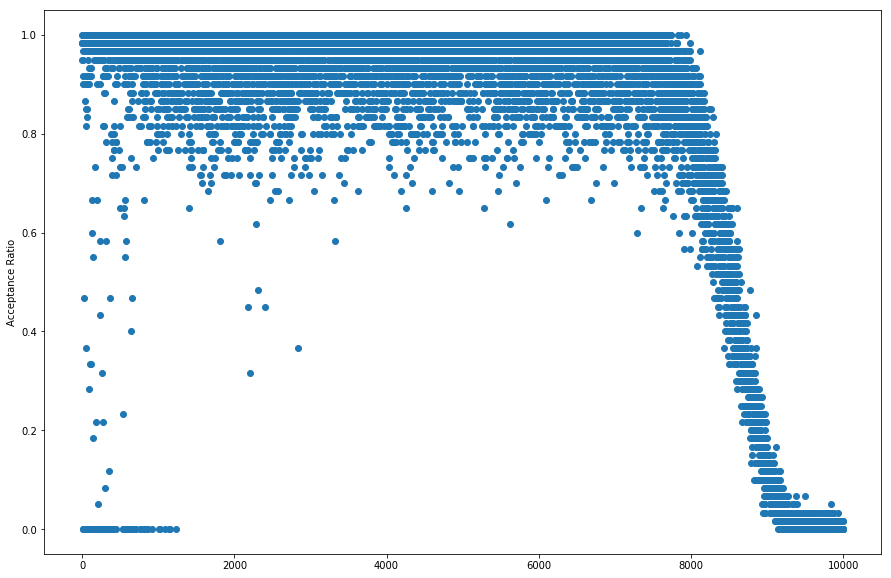

In [22]:
plt.figure(figsize=(15,10))
plt.plot(nacceptance,'o')
plt.ylabel('Acceptance Ratio')

Text(0.5,0,'$\\log(X)$')

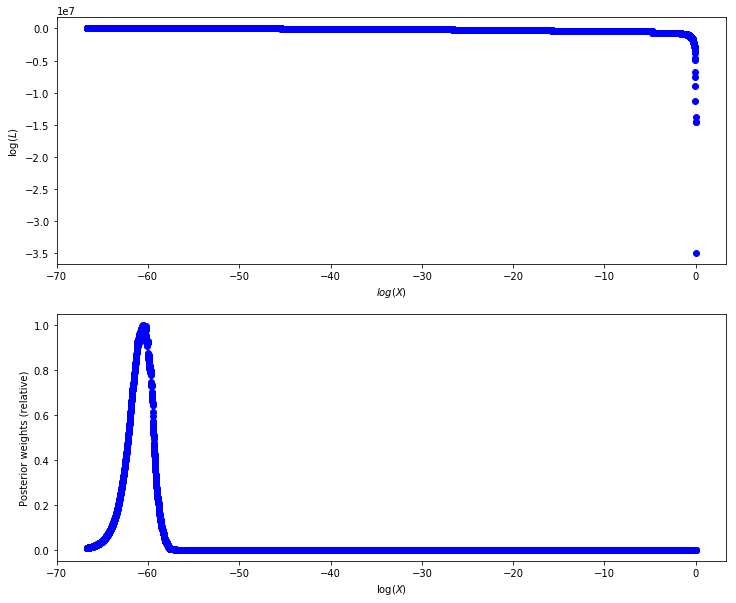

In [23]:
#Visualize Likelihood vs Prior Mass

plt.figure(figsize=(12,10))
plt.subplot(2,1,1)

#Plot LogL vs LogX
plt.plot(logX, keep[0:(nest_steps), -1], 'bo')
plt.ylabel('$\\log(L)$')
plt.xlabel('$log(X)$')



plt.subplot(2,1,2)

#Posterior weights
logwt = logX.copy() + keep[0:(nest_steps), -1]


# Normalised posterior weights
wt = np.exp(logwt - logwt.max())    

#Plot Posterior weights vs LogX
plt.plot(logX, wt, 'bo-')
plt.ylabel('Posterior weights (relative)')
plt.xlabel('$\\log(X)$')

In [24]:
# Useful function #Compute the log of the sum of exponentials of input elements.
# OR from scipy.misc import logsumexp 
def logsumexp(values):
    biggest = np.max(values)
    x = values - biggest
    result = np.log(np.sum(np.exp(x))) + biggest
    return result



# Prior weights
logw = logX.copy()

# Normalise them
logw -= logsumexp(logw)  

# Calculate marginal likelihood
logZ = logsumexp(logw + keep[:,-1])

# Normalised posterior weights
wt = wt/wt.sum()

#Calculate number of effective samples
effective_sample_size = int(np.exp(-np.sum(wt*np.log(wt + 1E-300))))

# Calculate information
H = np.sum(wt*(keep[:,-1] - logZ))

print('logZ = {logZ} '.format(logZ=logZ))
print('Information = {H}'.format(H=H))
print('Effective Sample Size = {ess}'.format(ess=effective_sample_size))

logZ = -1972.4931476820725 
Information = 59.32987437521047
Effective Sample Size = 805


# Compute the weighted Posterior results

In [25]:
#Empy array to save effective posterior samples
posterior_samples = np.empty((effective_sample_size, keep.shape[1]))
logX_effective = np.empty(effective_sample_size)

k = 0
while True:
  # Choose one of the samples
    which = np.random.randint(keep.shape[0])

  # Acceptance probability
    prob = wt[which]/wt.max()

    if np.random.rand() <= prob:
        posterior_samples[k, :] = keep[which, :]
        logX_effective[k] = logX[k]
        k += 1

    if k >= effective_sample_size:
        break

np.savetxt('keep_Many.txt', posterior_samples)

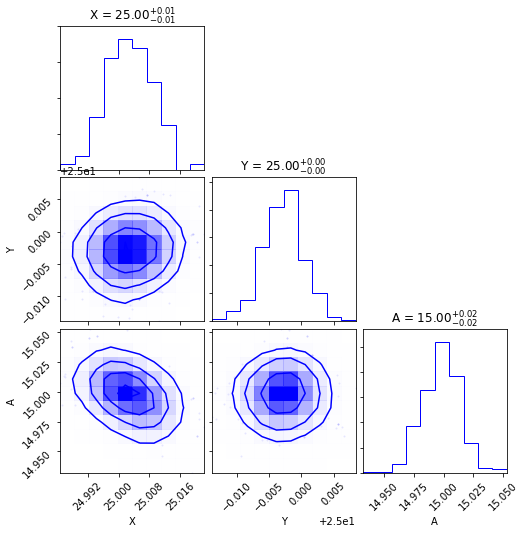

In [26]:
Fig = corner.corner(posterior_samples[:,:-1], labels=['X','Y','A'],bins=10,show_titles=True,color='b',smooth=1.0);

Text(0,0.5,'Arbitrary Flux')

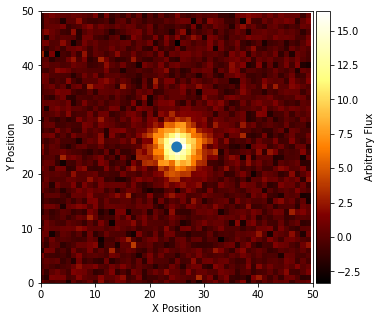

In [27]:
plt.figure(figsize=(7,5))
ax = plt.gca()
ellipses = []
plt.xlim([0,npix])
plt.ylim([0,npix])
X_pos = [np.mean(posterior_samples[:,0])]
Y_pos = [np.mean(posterior_samples[:,1])]
for ra, dec in zip(X_pos,Y_pos):
    ellipse = Ellipse(xy=(ra, dec), width=2, height=2, angle=0)
    ellipses.append(ellipse)

p = PatchCollection(ellipses)
ax.add_collection(p)

im = ax.imshow(Img_data,origin='lower',cmap='afmhot',)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
plt.ylabel('Arbitrary Flux')

# LogZ Distribution

In [28]:
#Empty list to store logZ
logZ_distribution = []  

# logZ sample size
NZ = 5000               

for i in range(NZ):   
    
    #Generate log uniform numbers (log space)
    uniform_numbers = np.log(np.random.uniform(0,1,len(keep[:,-1])))  
    
    #initialize number
    number_new = 0        
    
    #store each prior mass
    logX_mass = []   
    
     # for each log uniform number
    for number in uniform_numbers:                                   
    
        number_new -= number                                         # x1,x2,x3 = u1,u1*u2,u1*u2*u3 etc. in log space we add
        logX_mass.append(-number_new/N)                              # store each logx..

    logw_un = logX_mass                                             #prior weights
    logw_un -= logsumexp(logw_un)                                   #normalise them

    logZ_un = logsumexp(logw_un + keep[:,-1])                        #Evaluate logZ 
    
    logZ_distribution.append(logZ_un)                                #store each logZ 
    

/home/hope-moloko/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


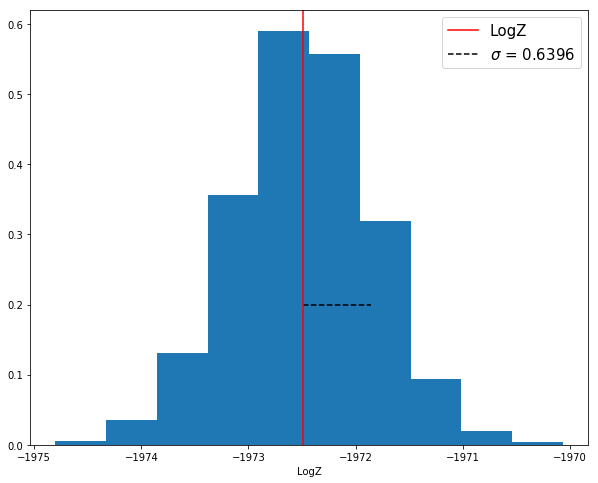

In [29]:
std = np.std(logZ_distribution)    # Standard deviation of logZ distribution

fig,ax = plt.subplots(figsize=(10,8))

ax.hist(logZ_distribution,normed=True);
ax.axvline(logZ,c='r',label = 'LogZ')
ax.set_xlabel('LogZ')
ax.axes.hlines(.2,logZ,logZ+std,linestyle='dashed',label='$\sigma$ = ' +str(np.round(std,4)))
ax.legend(fontsize=15)